In [1]:
import numpy as np  
import pandas as pd  
from pylab import plt
import matplotlib as mlib
plt.style.use('seaborn')
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve

In [2]:
data = pd.read_csv('D:/CQF/0175.HK.csv', index_col=0, usecols=[0,5]) # 5-year stock price of Geely
data.columns = ['price']  # Adj Close Price
data = data.rename(columns={data.columns[0]: 'price'})

In [3]:
data.head()

,price
Date,
2016-11-24,7.486081
2016-11-25,7.633774
2016-11-28,7.430698
2016-11-29,7.366083
2016-11-30,7.403007


In [4]:
data.columns

Index(['price'], dtype='object')

<AxesSubplot:xlabel='Date'>

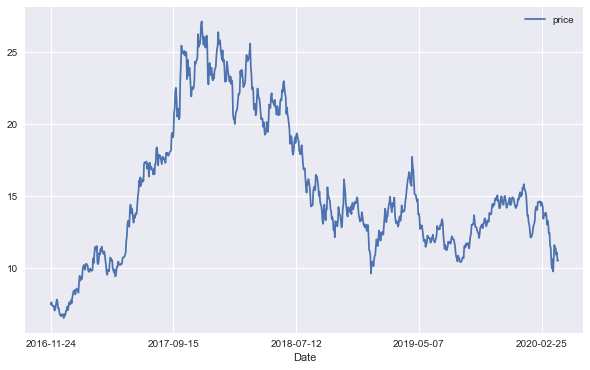

In [5]:
data.plot(figsize=(10, 6))

In [6]:
data['Returns'] = np.log(data).diff()

data.head() # Add daily Log return to the data frame

,price,Returns
Date,,
2016-11-24,7.486081,NaN
2016-11-25,7.633774,0.019537
2016-11-28,7.430698,-0.026963
2016-11-29,7.366083,-0.008734
2016-11-30,7.403007,0.005000


<AxesSubplot:xlabel='Date'>

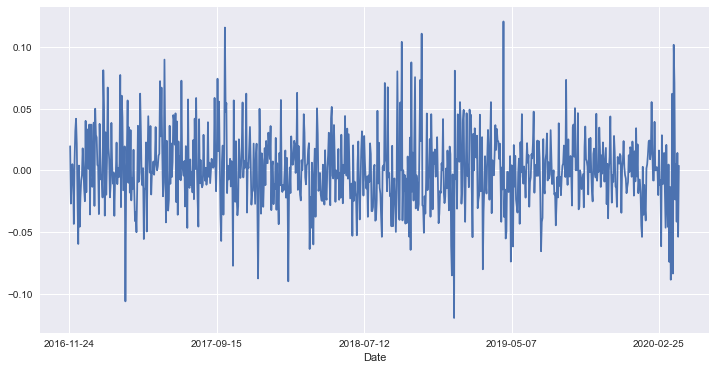

In [7]:
data['Returns'].plot(figsize=(12, 6)) # time series of daily log return

In [8]:
lags = 5 # include 5 past returns

cols = []

for lag in range(1, lags+1):
    col = 'rt_%d' % lag
    data[col] = data['Returns'].shift(lag)
    cols.append(col)

In [9]:
data.head()

,price,Returns,rt_1,rt_2,rt_3,rt_4,rt_5
Date,,,,,,,
2016-11-24,7.486081,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-25,7.633774,0.019537,NaN,NaN,NaN,NaN,NaN
2016-11-28,7.430698,-0.026963,0.019537,NaN,NaN,NaN,NaN
2016-11-29,7.366083,-0.008734,-0.026963,0.019537,NaN,NaN,NaN
2016-11-30,7.403007,0.005000,-0.008734,-0.026963,0.019537,NaN,NaN


In [10]:
data.dropna(inplace=True)

data['return_sign'] = np.sign(data['Returns'].values) 
# create return sign, if return > 0, its sign will be 1,
# if return = 0, its sign will be 0, if return < 0, its sign will be -1
data['return_sign'].replace(0.0,-1.0, inplace=True) # convert all zeros to -1 for the sake of classification

data.head()

,price,Returns,rt_1,rt_2,rt_3,rt_4,rt_5,return_sign
Date,,,,,,,,
2016-12-02,7.061471,-0.043485,-0.003748,0.005000,-0.008734,-0.026963,0.019537,-1.0
2016-12-05,7.116855,0.007813,-0.043485,-0.003748,0.005000,-0.008734,-0.026963,1.0
2016-12-06,7.347621,0.031911,0.007813,-0.043485,-0.003748,0.005000,-0.008734,1.0
2016-12-07,7.661465,0.041827,0.031911,0.007813,-0.043485,-0.003748,0.005000,1.0
2016-12-08,7.827616,0.021455,0.041827,0.031911,0.007813,-0.043485,-0.003748,1.0


In [11]:
# Create a set of features, including momentum, moving average and exponential moving average
def createFeatures(df): 
    df['momentum_1d']=df['price']-df['price'].shift(periods=1)
    # df['momentum_2d']=df['price']-df['price'].shift(periods=2)
    # df['momentum_3d']=df['price']-df['price'].shift(periods=3)
    # df['momentum_4d']=df['price']-df['price'].shift(periods=4)
    df['momentum_5d']=df['price']-df['price'].shift(periods=5)
    df['momentum_10d']=df['price']-df['price'].shift(periods=10)
    df['momentum_20d']=df['price']-df['price'].shift(periods=20)
    df['momentum_50d']=df['price']-df['price'].shift(periods=50)
    
    df['MA_5d']=df['price'].rolling(5).mean() # Moving average
    df['MA_10d']=df['price'].rolling(10).mean()
    df['MA_15d']=df['price'].rolling(15).mean()
    # df['MA_20d']=df['price'].rolling(20).mean()

    df['EMA_5d']=df['price'].ewm(5, adjust=False).mean() # Exponential Moving average
    df['EMA_10d']=df['price'].ewm(10, adjust=False).mean()
    df['EMA_15d']=df['price'].ewm(15, adjust=False).mean()
    # df['EMA_20d']=df['price'].ewm(20, adjust=False).mean()
    
    return df

In [12]:
createFeatures(data)
data.dropna(inplace=True)
data.head()

,price,Returns,rt_1,rt_2,rt_3,rt_4,rt_5,return_sign,momentum_1d,momentum_5d,momentum_10d,momentum_20d,momentum_50d,MA_5d,MA_10d,MA_15d,EMA_5d,EMA_10d,EMA_15d
Date,,,,,,,,,,,,,,,,,,,
2017-02-17,9.895290,-0.011132,-0.021899,0.009066,0.018383,0.067139,0.007968,-1.0,-0.110768,0.590765,0.895376,1.707677,2.833819,10.042980,9.676522,9.310064,9.591514,9.111556,8.756609
2017-02-20,10.282978,0.038431,-0.011132,-0.021899,0.009066,0.018383,0.067139,1.0,0.387688,0.332304,0.812300,1.873828,3.166123,10.109441,9.757752,9.423294,9.706758,9.218049,8.852007
2017-02-21,10.319901,0.003584,0.038431,-0.011132,-0.021899,0.009066,0.018383,1.0,0.036923,0.184615,1.190757,1.873829,2.972280,10.146364,9.876828,9.543293,9.808949,9.318218,8.943750
2017-02-22,10.209133,-0.010791,0.003584,0.038431,-0.011132,-0.021899,0.009066,-1.0,-0.110768,-0.018461,0.793838,1.735368,2.547668,10.142672,9.956212,9.658369,9.875646,9.399210,9.022837
2017-02-23,10.190671,-0.001810,-0.010791,0.003584,0.038431,-0.011132,-0.021899,-1.0,-0.018462,0.184613,0.959991,2.012288,2.363055,10.179595,10.052211,9.784521,9.928150,9.471161,9.095826


In [13]:
data2 = data.drop(columns="price",axis=1)
data2

,Returns,rt_1,rt_2,rt_3,rt_4,rt_5,return_sign,momentum_1d,momentum_5d,momentum_10d,momentum_20d,momentum_50d,MA_5d,MA_10d,MA_15d,EMA_5d,EMA_10d,EMA_15d
Date,,,,,,,,,,,,,,,,,,
2017-02-17,-0.011132,-0.021899,0.009066,0.018383,0.067139,0.007968,-1.0,-0.110768,0.590765,0.895376,1.707677,2.833819,10.042980,9.676522,9.310064,9.591514,9.111556,8.756609
2017-02-20,0.038431,-0.011132,-0.021899,0.009066,0.018383,0.067139,1.0,0.387688,0.332304,0.812300,1.873828,3.166123,10.109441,9.757752,9.423294,9.706758,9.218049,8.852007
2017-02-21,0.003584,0.038431,-0.011132,-0.021899,0.009066,0.018383,1.0,0.036923,0.184615,1.190757,1.873829,2.972280,10.146364,9.876828,9.543293,9.808949,9.318218,8.943750
2017-02-22,-0.010791,0.003584,0.038431,-0.011132,-0.021899,0.009066,-1.0,-0.110768,-0.018461,0.793838,1.735368,2.547668,10.142672,9.956212,9.658369,9.875646,9.399210,9.022837
2017-02-23,-0.001810,-0.010791,0.003584,0.038431,-0.011132,-0.021899,-1.0,-0.018462,0.184613,0.959991,2.012288,2.363055,10.179595,10.052211,9.784521,9.928150,9.471161,9.095826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,0.005115,-0.023650,0.070903,0.101783,-0.083699,0.062108,1.0,0.058166,0.775525,-1.066346,-2.035752,-4.032730,10.989191,10.900006,11.546277,11.355296,11.932272,12.359207
2020-03-30,-0.041673,0.005115,-0.023650,0.070903,0.101783,-0.083699,-1.0,-0.465317,1.163286,-0.639810,-2.888832,-4.381719,11.221848,10.836025,11.406682,11.285231,11.841602,12.270188
2020-03-31,0.014085,-0.041673,0.005115,-0.023650,0.070903,0.101783,1.0,0.155106,0.271433,-0.329598,-2.578622,-3.955179,11.276135,10.803065,11.259332,11.252694,11.773275,12.196427


Text(0.5, 1.0, 'Feature Correlation')

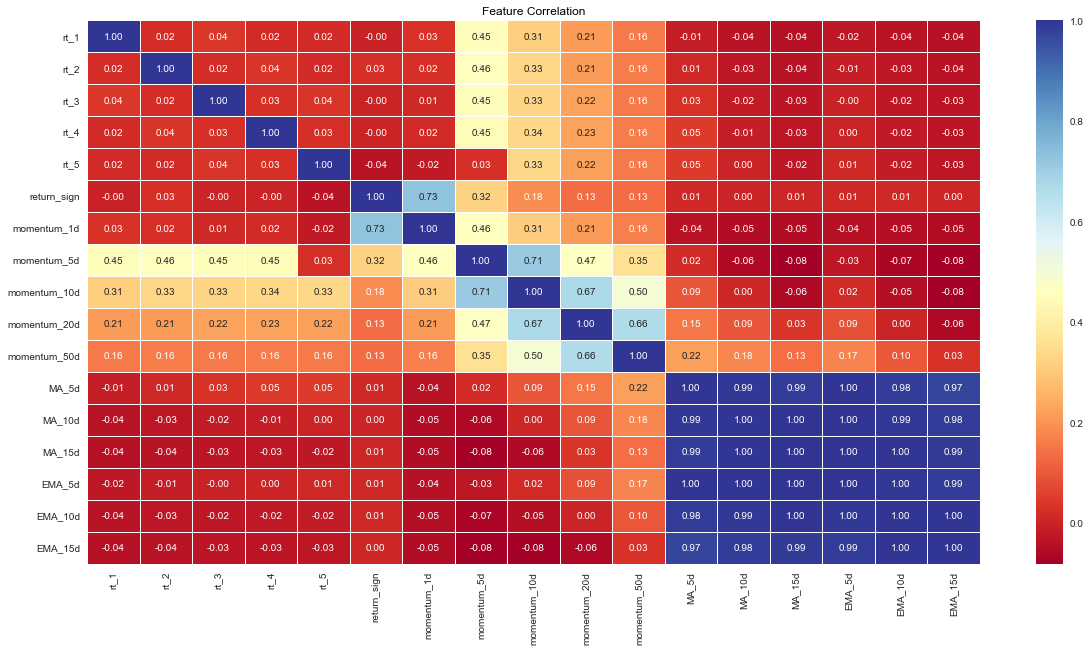

In [14]:
import seaborn as sns
corrmat = data2.drop(['Returns'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap='RdYlBu')
ax.set_title('Feature Correlation', fontsize=12, color='black')

In [15]:
data3 = data2.drop(['return_sign','Returns'],axis=1)
data3.head()

,rt_1,rt_2,rt_3,rt_4,rt_5,momentum_1d,momentum_5d,momentum_10d,momentum_20d,momentum_50d,MA_5d,MA_10d,MA_15d,EMA_5d,EMA_10d,EMA_15d
Date,,,,,,,,,,,,,,,,
2017-02-17,-0.021899,0.009066,0.018383,0.067139,0.007968,-0.110768,0.590765,0.895376,1.707677,2.833819,10.042980,9.676522,9.310064,9.591514,9.111556,8.756609
2017-02-20,-0.011132,-0.021899,0.009066,0.018383,0.067139,0.387688,0.332304,0.812300,1.873828,3.166123,10.109441,9.757752,9.423294,9.706758,9.218049,8.852007
2017-02-21,0.038431,-0.011132,-0.021899,0.009066,0.018383,0.036923,0.184615,1.190757,1.873829,2.972280,10.146364,9.876828,9.543293,9.808949,9.318218,8.943750
2017-02-22,0.003584,0.038431,-0.011132,-0.021899,0.009066,-0.110768,-0.018461,0.793838,1.735368,2.547668,10.142672,9.956212,9.658369,9.875646,9.399210,9.022837
2017-02-23,-0.010791,0.003584,0.038431,-0.011132,-0.021899,-0.018462,0.184613,0.959991,2.012288,2.363055,10.179595,10.052211,9.784521,9.928150,9.471161,9.095826


In [16]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(data3, data2['return_sign'], test_size=0.2, random_state=0, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 617, 155


In [17]:
from sklearn import linear_model 

In [18]:
# Logistic classifier without penalty term
original =  Pipeline([
    ('scalar', StandardScaler()), # Standarize the training set
    ('regressor', linear_model.LogisticRegression(solver='saga', penalty='none', max_iter=100000))
])

original.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 LogisticRegression(max_iter=100000, penalty='none',
                                    solver='saga'))])

In [19]:
# Lasso Logistic Regression
lasso = Pipeline([
    ('scalar', StandardScaler()),
    ('regressor', linear_model.LogisticRegression(solver='saga', penalty='l1', max_iter=100000))
])

lasso.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 LogisticRegression(max_iter=100000, penalty='l1',
                                    solver='saga'))])

In [20]:
# Ridge Logistic Regression
ridge = Pipeline([
    ('scalar', StandardScaler()),
    ('regressor', linear_model.LogisticRegression(solver='saga', penalty='l2', max_iter=100000))
])

ridge.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 LogisticRegression(max_iter=100000, solver='saga'))])

In [21]:
original['regressor'].coef_ # Model coefficients

array([[-0.57310255, -0.33841461,  0.15160786,  0.23806262,  0.09446389,
        52.90661194, -0.34926408,  0.31311821,  0.45307652,  1.86478302,
        -4.77195538, -5.2879333 ,  0.91791203, -1.74109945,  3.73569932,
         6.60958321]])

In [22]:
lasso['regressor'].coef_

array([[-4.06943471e-03, -4.50223381e-02,  9.65514339e-02,
         0.00000000e+00,  0.00000000e+00,  2.23450534e+01,
         0.00000000e+00,  0.00000000e+00, -1.35240107e-01,
         2.70393883e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [23]:
ridge['regressor'].coef_

array([[-4.65345398e-01, -3.86444395e-01, -3.42763877e-01,
        -3.72408733e-01, -9.71560001e-02,  7.46322170e+00,
         1.11537216e+00, -1.90963545e-01,  2.67312609e-03,
         2.09338716e-01, -2.41261801e-01, -1.08298863e-01,
         6.74116123e-02, -3.27941453e-02,  1.85250205e-01,
         2.67634963e-01]])

In [24]:
data3.columns # Names of features

Index(['rt_1', 'rt_2', 'rt_3', 'rt_4', 'rt_5', 'momentum_1d', 'momentum_5d',
       'momentum_10d', 'momentum_20d', 'momentum_50d', 'MA_5d', 'MA_10d',
       'MA_15d', 'EMA_5d', 'EMA_10d', 'EMA_15d'],
      dtype='object')

In [25]:
original_coef = pd.DataFrame(original['regressor'].coef_.tolist(), index=['Without penalty'], columns=data3.columns)
lasso_coef = pd.DataFrame(lasso['regressor'].coef_.tolist(), index=['Lasso'], columns=data3.columns)
ridge_coef = pd.DataFrame(ridge['regressor'].coef_.tolist(), index=['Ridge'], columns=data3.columns)

# Compare coefficients of 3 models
df = pd.DataFrame(columns=data3.columns)
df1 = df.append(original_coef, ignore_index=False)
df2 = df1.append(lasso_coef, ignore_index=False)
df3 = df2.append(ridge_coef, ignore_index=False)
df3
# Lasso shrinks a lot of coefficients to 0

,rt_1,rt_2,rt_3,rt_4,rt_5,momentum_1d,momentum_5d,momentum_10d,momentum_20d,momentum_50d,MA_5d,MA_10d,MA_15d,EMA_5d,EMA_10d,EMA_15d
Without penalty,-0.573103,-0.338415,0.151608,0.238063,0.094464,52.906612,-0.349264,0.313118,0.453077,1.864783,-4.771955,-5.287933,0.917912,-1.741099,3.735699,6.609583
Lasso,-0.004069,-0.045022,0.096551,0.000000,0.000000,22.345053,0.000000,0.000000,-0.135240,0.270394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ridge,-0.465345,-0.386444,-0.342764,-0.372409,-0.097156,7.463222,1.115372,-0.190964,0.002673,0.209339,-0.241262,-0.108299,0.067412,-0.032794,0.185250,0.267635


In [26]:
data4 = data3.copy()

In [27]:
def logistic_sigmoid(xb):
    return (1 / (1 + np.exp(-xb)))

In [28]:
#Procedure RELIES X_Features, Y_Response variables to be existing
def logistic_plot(FeatureName, FeatureCoefIdx, model):  
    plt.clf() #clears the figure drawing space, nothing to do with classifier!
    fig, ax = plt.subplots(figsize=(18,10))  #fig = plt.figure(figsize=(18,10))

    X_min = data4[FeatureName].min(axis=0)
    X_max = data4[FeatureName].max(axis=0)
    # 2. Plot CALIBRATED sigmoid function -- with the correctly picked coeffient from Logistic Regression
    X_Sim = np.linspace(X_min, X_max, 100) #fill in values for the range of Axe X
    Y_Loss = logistic_sigmoid(X_Sim * model['regressor'].coef_[0,FeatureCoefIdx] + model['regressor'].intercept_) 
    # Y_Loss = logistic_sigmoid(X_Sim * logit.coef_[0,FeatureBetaIdx] + logit.intercept_).ravel() 
    ax.plot(X_Sim, Y_Loss, color='red', linewidth=3) # plot sigmoid in Red
      
    plt.ylabel('sigmoid', fontsize=22) # also ax.set_ylabel('Default Indicator')
    plt.xlabel('Feature: ' + FeatureName, fontsize=22)
    plt.xticks(np.linspace(X_min, X_max, num=10), fontsize=14)
    plt.yticks([-1, 1], fontsize=14)
    plt.ylim(-1.1, 1.1)
    plt.xlim(X_min, X_max) #Axe X range
    plt.legend(('Logistic Regression',),
           loc="lower right", fontsize=14)
    #plt.show()
    return ax

<AxesSubplot:xlabel='Feature: momentum_1d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

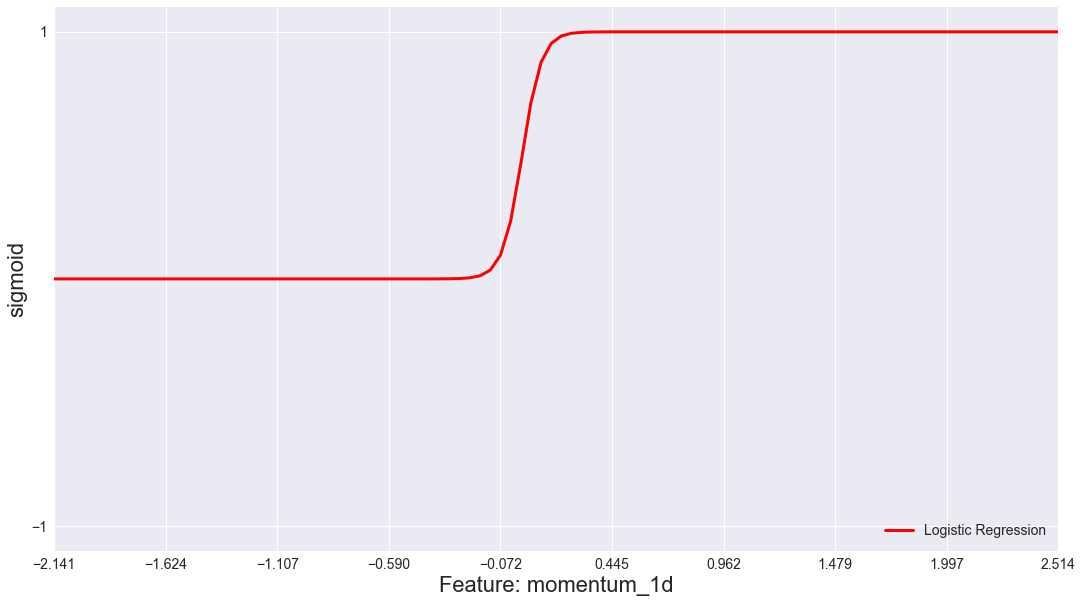

In [29]:
logistic_plot('momentum_1d', 5, lasso) # Logistic sigmoid of momentum_1d under lasso

<AxesSubplot:xlabel='Feature: momentum_50d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

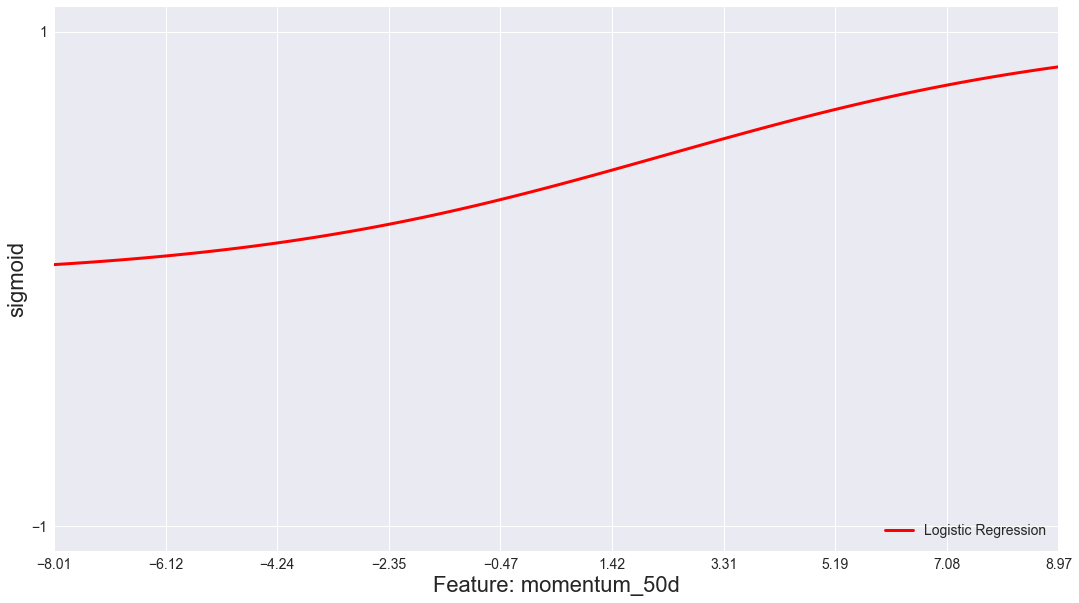

In [30]:
logistic_plot('momentum_50d', 9, lasso)

<AxesSubplot:xlabel='Feature: momentum_20d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

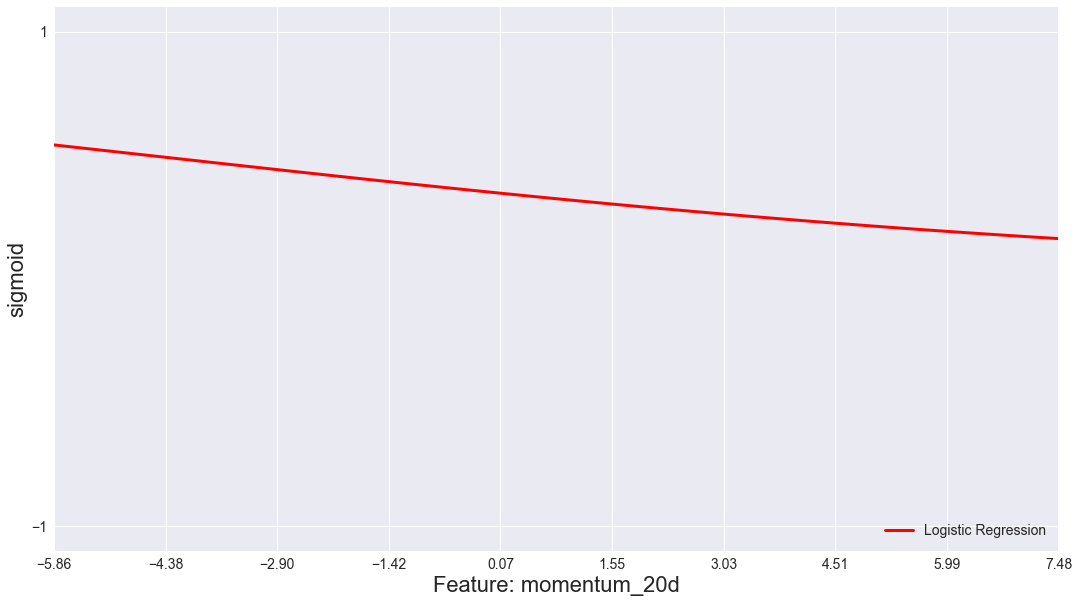

In [31]:
logistic_plot('momentum_20d', 8, lasso)

<AxesSubplot:xlabel='Feature: momentum_1d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

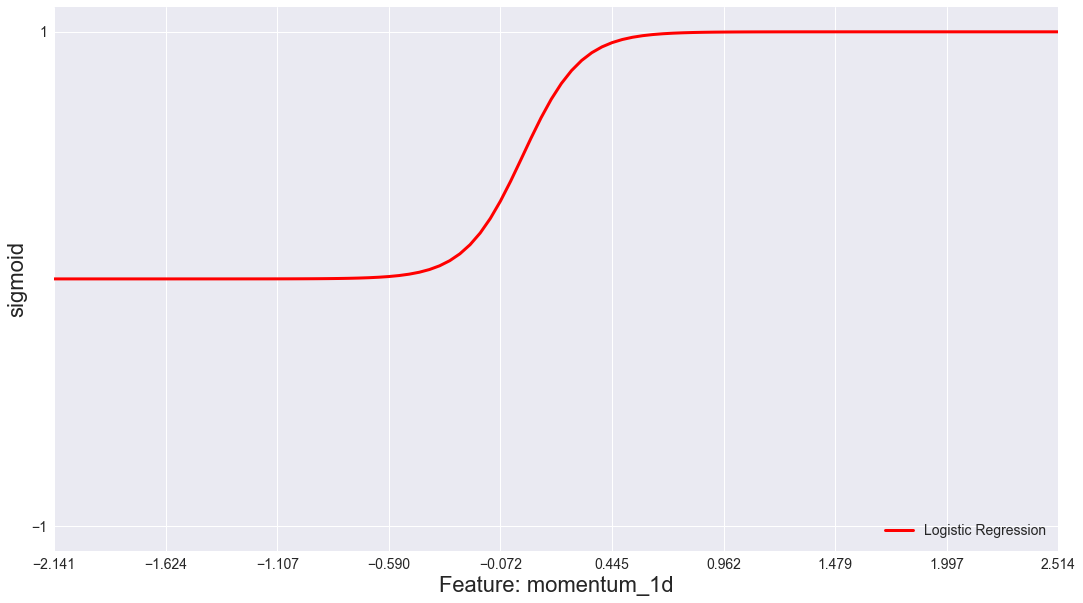

In [32]:
logistic_plot('momentum_1d', 5, ridge)

<AxesSubplot:xlabel='Feature: momentum_5d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

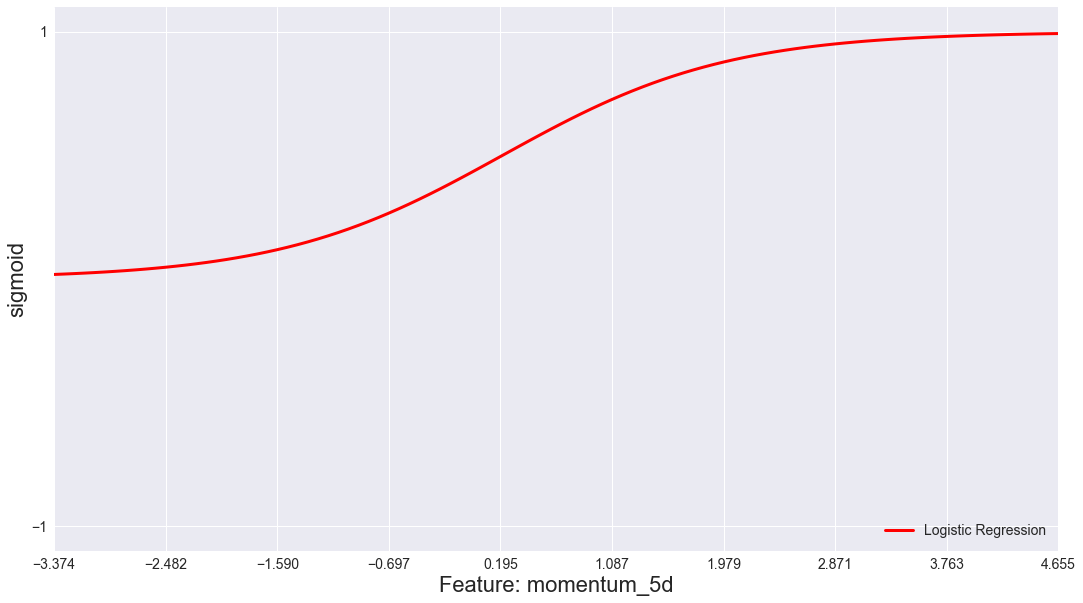

In [33]:
logistic_plot('momentum_5d', 6, ridge)

<AxesSubplot:xlabel='Feature: EMA_15d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

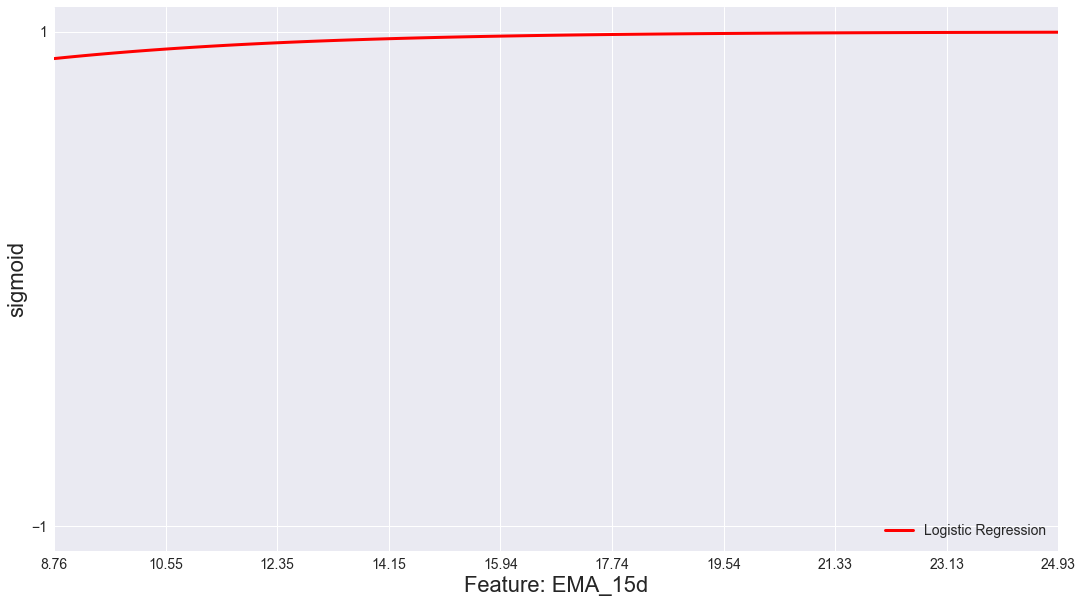

In [34]:
logistic_plot('EMA_15d', 15, ridge)

In [35]:
# Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [36]:
# For each X, calculate VIF and save in dataframe
def vif(X):
    
    # perform feature scaling
    scaler = StandardScaler()
    xs = scaler.fit_transform(X)
    
    # subsume into a dataframe
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    
    return vif

In [37]:
vif(X_train).round(2)

,Features,VIF Factor
0,rt_1,6.18
1,rt_2,4.80
2,rt_3,4.06
3,rt_4,7.74
4,rt_5,2.42
5,momentum_1d,6.58
6,momentum_5d,25.26
7,momentum_10d,16.14
8,momentum_20d,16.07
9,momentum_50d,11.55


In [38]:
# Drop VIF score > 30
newX = X_train.drop(['MA_5d', 'MA_10d', 'MA_15d', 'EMA_5d', 'EMA_10d', 'EMA_15d'],axis=1)
# Scores in ascending values
vif(newX).sort_values(by="VIF Factor")

,Features,VIF Factor
4,rt_5,1.251785
9,momentum_50d,1.765668
8,momentum_20d,2.471240
7,momentum_10d,3.328463
1,rt_2,3.921142
3,rt_4,3.933452
0,rt_1,3.946196
2,rt_3,3.949299
5,momentum_1d,4.164979
6,momentum_5d,18.376974


In [39]:
X_candidate = X_train[['rt_1', 'rt_2', 'rt_3', 'rt_4', 'rt_5', 'momentum_10d', 'momentum_20d', 'momentum_50d']]

In [40]:
# Feature Selection
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile

In [41]:
# SelectKBest
# selector1 = SelectPercentile(f_regression, percentile=25)
method2 =  SelectKBest(f_regression, k=6) 

# Fit the model
method2.fit(X_candidate,y_train)

SelectKBest(k=6, score_func=<function f_regression at 0x0000017C3D309940>)

In [42]:
# Iterate the score
for f, s in zip(X_candidate.columns, method2.scores_):
    print(f'F-score: {s:0.4} for feature {f}')

F-score: 0.006329 for feature rt_1
F-score: 0.4136 for feature rt_2
F-score: 0.451 for feature rt_3
F-score: 0.8642 for feature rt_4
F-score: 1.874 for feature rt_5
F-score: 26.77 for feature momentum_10d
F-score: 14.38 for feature momentum_20d
F-score: 12.72 for feature momentum_50d


In [43]:
# Filter six features with highest score
X_Kbest = X_train[['rt_5', 'momentum_10d', 'momentum_20d' ,'momentum_50d']]

In [44]:
lasso2 = Pipeline([
    ('scalar', StandardScaler()),
    ('regressor', linear_model.LogisticRegression(solver='saga', penalty='l1', max_iter=100000))
])

lasso2.fit(X_Kbest, y_train)


Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 LogisticRegression(max_iter=100000, penalty='l1',
                                    solver='saga'))])

In [45]:
ridge2 = Pipeline([
    ('scalar', StandardScaler()),
    ('regressor', linear_model.LogisticRegression(solver='saga', penalty='l2', max_iter=100000))
])

ridge2.fit(X_Kbest, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('regressor',
                 LogisticRegression(max_iter=100000, solver='saga'))])

<AxesSubplot:xlabel='Feature: rt_5', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

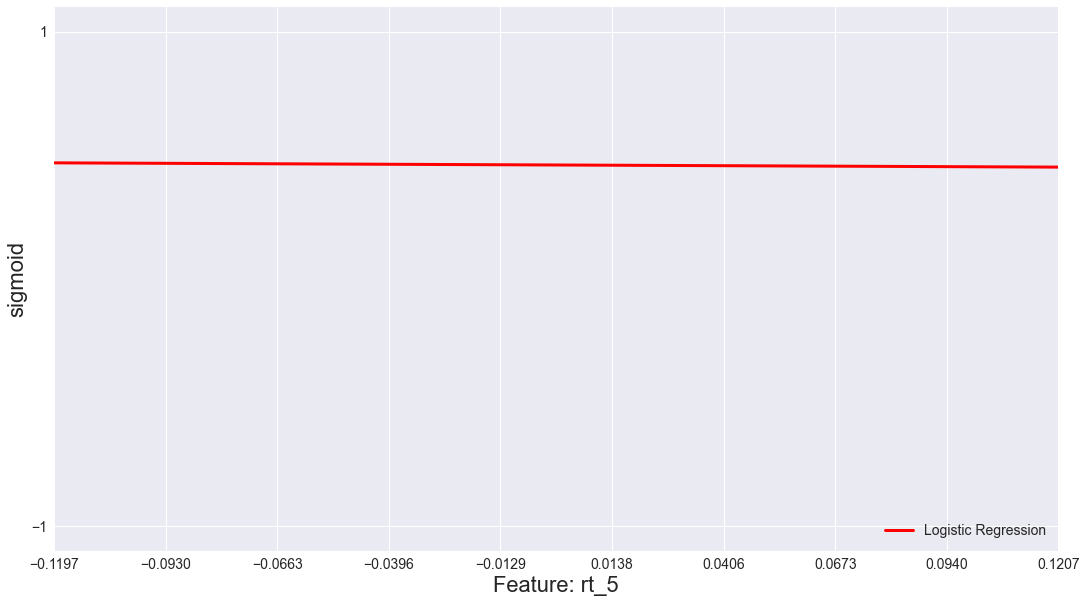

In [46]:
logistic_plot('rt_5',0,ridge2)

<AxesSubplot:xlabel='Feature: momentum_10d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

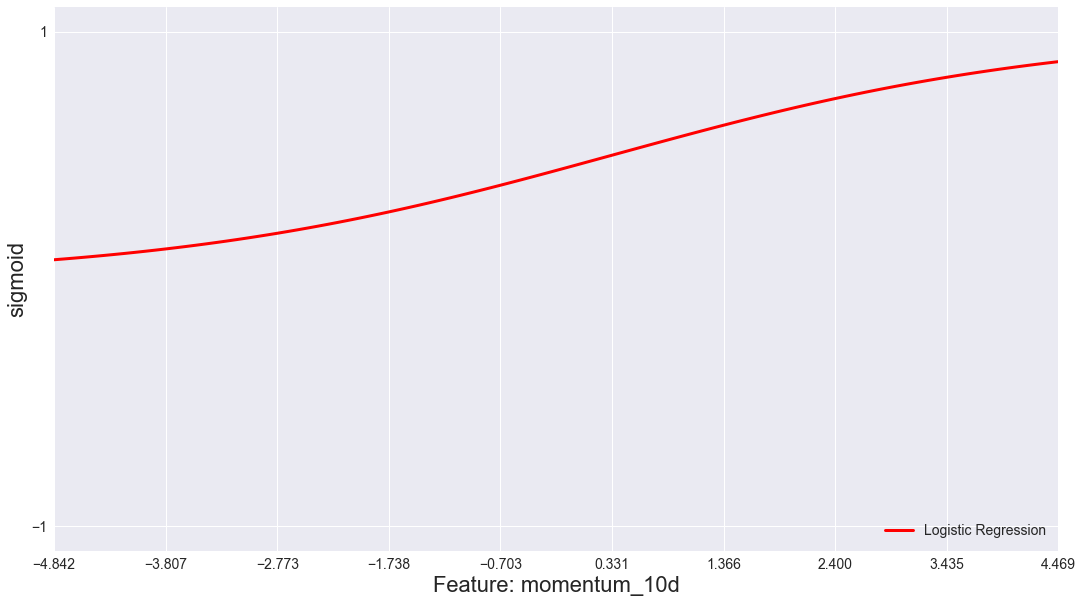

In [47]:
logistic_plot('momentum_10d',1,ridge2)

<AxesSubplot:xlabel='Feature: momentum_20d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

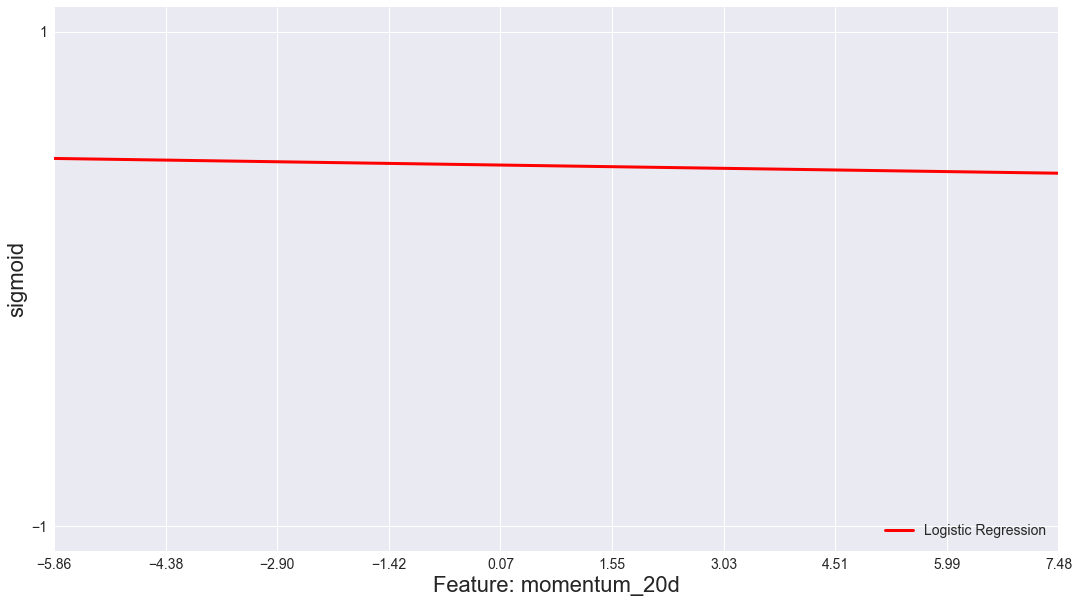

In [48]:
logistic_plot('momentum_20d',2,ridge2)

<AxesSubplot:xlabel='Feature: momentum_50d', ylabel='sigmoid'>

<Figure size 432x288 with 0 Axes>

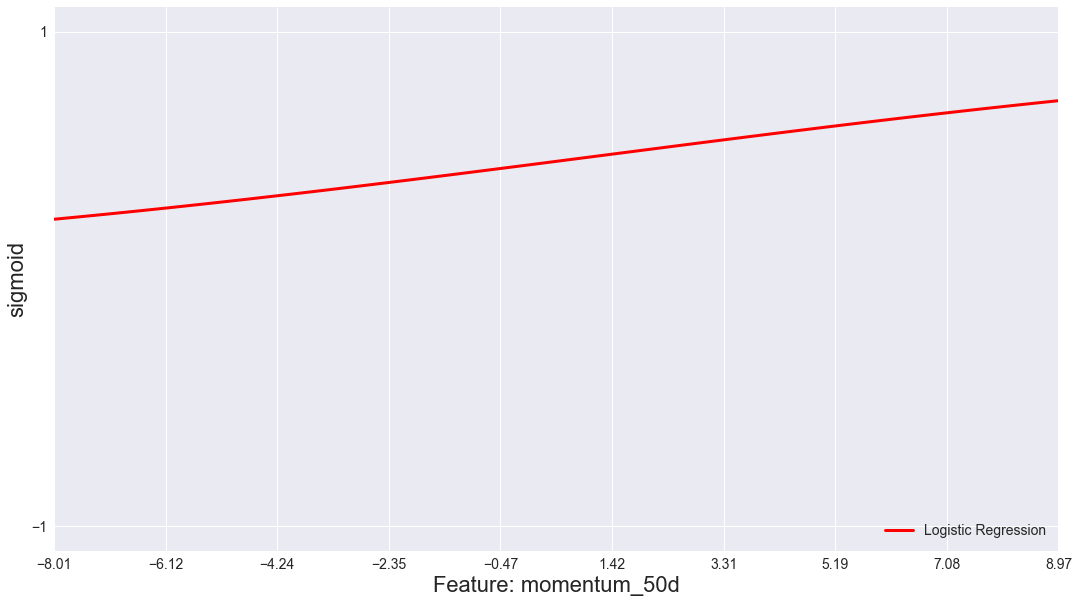

In [49]:
logistic_plot('momentum_50d',3,ridge2)

In [50]:
X_Ktest = X_test[['rt_5', 'momentum_10d', 'momentum_20d' ,'momentum_50d']] # new test set

In [51]:
# Predict Probabilities
probs = ridge2.predict_proba(X_Ktest)
preds1 = probs[:, 0]
preds2 = probs[:, 1]

fpr1, tpr1, threshold1 = roc_curve(y_test, preds1, pos_label=-1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y_test, preds2, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)

(<matplotlib.legend.Legend at 0x17c3f6cbfa0>,
 <matplotlib.legend.Legend at 0x17c3f3eff70>)

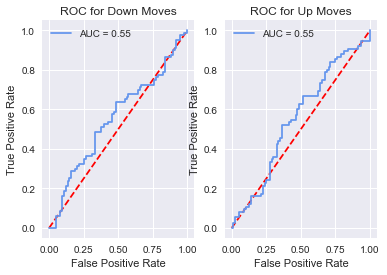

In [52]:
# Plot ROC curves
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot([0, 1], [0, 1], 'r--')
ax[0].plot(fpr1, tpr1, 'cornflowerblue', label=f'AUC = {roc_auc1:0.2}')
ax[0].set_title("ROC for Down Moves")
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].plot(fpr2, tpr2, 'cornflowerblue', label=f'AUC = {roc_auc2:0.2}')
ax[1].set_title("ROC for Up Moves")
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')

# Define legend
ax[0].legend(), ax[1].legend()

C:\Users\rog\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


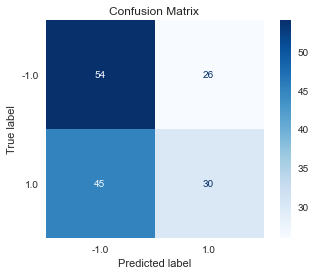

In [53]:
# Plot confusion matrix
plot_confusion_matrix(ridge2, X_Ktest, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [54]:
tn, fp, fn, tp = confusion_matrix(y_test,ridge2.predict(X_Ktest)).ravel()
print(tn, fp, fn, tp) # true negative, false positive, false negative, true positive

54 26 45 30


In [429]:
import cufflinks as cf
cf.set_config_file(offline=True)

In [485]:
X_Ktest2 = X_Ktest.copy()
X_Ktest2

,rt_5,momentum_10d,momentum_20d,momentum_50d
Date,,,,
2019-08-21,-0.005571,0.232658,-1.395944,-1.624811
2019-08-22,0.003717,0.639808,-0.697973,-0.452384
2019-08-23,0.005550,0.833691,-0.504091,-0.281127
2019-08-26,0.020092,0.756137,-0.562256,-0.348987
2019-08-27,0.003610,1.260228,-0.271434,-0.213270
...,...,...,...,...
2020-03-27,0.062108,-1.066346,-2.035752,-4.032730
2020-03-30,-0.083699,-0.639810,-2.888832,-4.381719
2020-03-31,0.101783,-0.329598,-2.578622,-3.955179


In [496]:
X_Ktest2['pred_sign'] = ridge2.predict(X_Ktest)
X_Ktest2['pred_d'] = preds1 # predicted probabilities of down moves
X_Ktest2['pred_u'] = preds2 # predicted probabilities of up moves
X_Ktest2['true_sign'] = y_test
X_Ktest2['cls'] = y_test
for i in range(X_Ktest2.shape[0]):
    if X_Ktest2.pred_sign[i] == X_Ktest2.true_sign[i]:
        X_Ktest2['cls'][i] = 1 
    else:
        X_Ktest2['cls'][i] = 0    
X_Ktest2

,rt_5,momentum_10d,momentum_20d,momentum_50d,pred_sign,pred_d,pred_u,true_sign,cls
Date,,,,,,,,,
2019-08-21,-0.005571,0.232658,-1.395944,-1.624811,-1.0,0.523693,0.476307,-1.0,1.0
2019-08-22,0.003717,0.639808,-0.697973,-0.452384,-1.0,0.507504,0.492496,1.0,0.0
2019-08-23,0.005550,0.833691,-0.504091,-0.281127,1.0,0.496775,0.503225,1.0,1.0
2019-08-26,0.020092,0.756137,-0.562256,-0.348987,-1.0,0.536942,0.463058,-1.0,1.0
2019-08-27,0.003610,1.260228,-0.271434,-0.213270,1.0,0.461492,0.538508,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-03-27,0.062108,-1.066346,-2.035752,-4.032730,-1.0,0.765557,0.234443,1.0,0.0
2020-03-30,-0.083699,-0.639810,-2.888832,-4.381719,1.0,0.424276,0.575724,-1.0,0.0
2020-03-31,0.101783,-0.329598,-2.578622,-3.955179,-1.0,0.792063,0.207937,1.0,0.0


In [549]:
idx_d = X_Ktest2['true_sign'] == -1
pic_d = X_Ktest2[['pred_d','cls']][idx_d]
idx_u = X_Ktest2['true_sign'] == 1
pic_u = X_Ktest2[['pred_u','cls']][idx_u]

C:\Users\rog\anaconda3\lib\site-packages\matplotlib\collections.py:1120: UserWarning:

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.



Text(0.5, 1.0, 'Transition Probabilities of Down Moves')

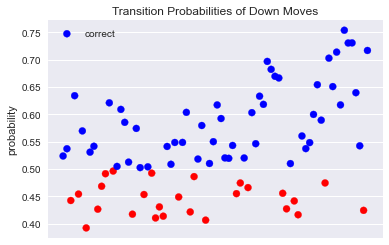

In [550]:
# Plot transition probabilities
cl = np.where(pic_d.cls == 1, 'blue', 'red') # blue points for correct predictions, red points for false predictions
fig, ax = plt.subplots()
pic_1 = ax.scatter(pic_d.index, pic_d.pred_d, c=cl, label='correct')
plt.ylabel('probability')
plt.xticks([])
legend1 = ax.legend(*pic_1.legend_elements(num = 2))
plt.legend()
plt.title('Transition Probabilities of Down Moves')

Text(0.5, 1.0, 'Transition Probabilities of Up Moves')

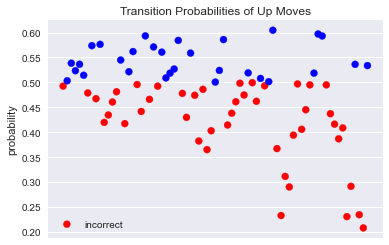

In [552]:
cl2 = np.where(pic_u.cls == 1, 'blue', 'red')
pic_1 = plt.scatter(pic_u.index, pic_u.pred_u, c=cl2, label='incorrect')
plt.xticks([])
plt.ylabel('probability')
plt.legend(loc='lower left')
plt.title('Transition Probabilities of Up Moves')

# Model performance is not very impressive, feature selection and hyperparameter tuning need to be refined later ! ! !